# graph-based SLAMの例

千葉工業大学 上田 隆一

(c) 2017 Ryuichi Ueda

This software is released under the MIT License, see LICENSE.

## はじめに

このコードは、http://ieeexplore.ieee.org/document/5681215/ に掲載されているSLAMの手法を、ミニマムな問題で具体的に説明するためのものです。アルゴリズムの説明は問題の定義から始めるのが普通ですが、Jupyter notebookの特性を生かして、コード中でダラダラ説明していくことにします。アルゴリズムの名前は（本来は総称なのだと思いますが）graph-based SLAMとしておきます。

また、 https://github.com/ryuichiueda/commentary_on_graph-based_slam/blob/master/commentary_on_graph-based_slam.pdf に数式の解説を書いていますので、こちらもご参考ください。

## コードの流れ

graph-based SLAMはオフライン手法で、先にロボットが計算に必要なデータを集めて、その後にSLAMの計算をします。


## ヘッダ

ヘッダです。計算に対してはnumpy以外、特に変わったものは使いません。

In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing

## ランドマークの管理クラス

配列でもいいのですが、描画の関係で一つのクラスで複数のランドマークの位置を管理するという方式にしています。ランドマークの位置は、世界座標系のx,y座標で表されます。このランドマークをロボットが見ると、どのランドマークか（ランドマークのID）、ロボットからの距離と見える方角、あとはランドマークのどの面が見えるかの4つの値が雑音付きで得られると仮定します。ランドマークのIDは、self.positionsのリストでの位置（0,1,2,...）とします。

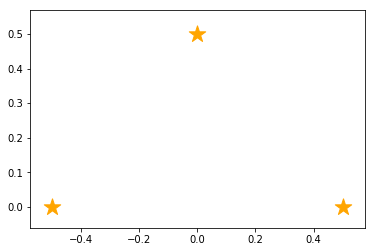

In [2]:
class Landmarks:
    def __init__(self,array):
        self.positions = array                          #各ランドマークの位置を記録（シミュレーションのためで、ロボットからは見えない情報）
    
    def draw(self):                                         #描画用
        xs = [ e[0] for e in self.positions]
        ys = [ e[1] for e in self.positions]
        plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
        
# ランドマークを3つ登録
actual_landmarks = Landmarks(np.array([[-0.5,0.0],[0.5,0.0],[0.0,0.5]]))

#　ランドマークを描画してみましょう
actual_landmarks.draw()

### 観測値の管理クラス

Observationは、ロボットが1個のランドマークを見たときに得た情報を管理します。

In [3]:
class Observation:
    
    # コンストラクタ: ロボットの真の位置とランドマークの真の位置、ランドマークのIDが引数
    # もちろん、ロボットの真の位置とランドマークの真の位置はロボットから見えないので、
    # センサの値をシミュレーションで生成するだけのために用います。
    # TODO: このクラスからはセンサのクラスを分離した方がいいかもしれない。
    def __init__(self,robot_pos, landmark,lid): 
        #観測可能な範囲の設定（XXX: クラス変数にすべき）
        self.sensor_max_range = 1.0
        self.sensor_min_range = 0.1
        self.sensor_max_angle = math.pi / 2
        self.sensor_min_angle = - math.pi /2 
        
        #ランドマークのIDの初期化。観測に失敗したらNoneのまま
        self.lid = None
        
        #t実際の値。くどいようですが、ロボットは本来知らない値。シミュレーション用。
        rx,ry,rt = robot_pos[0],robot_pos[1],robot_pos[2]
        lx,ly = landmark[0],landmark[1]
        
        #ランドマークの距離の真値を求める
        distance = math.sqrt((rx-lx)**2 + (ry-ly)**2)
        if distance > self.sensor_max_range or distance < self.sensor_min_range:  #計測範囲外なら終了
            return
        
        #ランドマークが見える方向の真値を求める。
        direction = math.atan2(ly-ry, lx-rx) - rt
        if direction > math.pi:    direction -= 2*math.pi
        if direction < -math.pi:   direction += 2*math.pi     
        if direction > self.sensor_max_angle or direction < self.sensor_min_angle:  #計測範囲外なら終了
            return
        
        #ランドマークが世界座標系でどちらを向いているかを計算。ランドマークに方角があることを仮定。
        #実機では、2地点で撮影した画像から、2地点の相対的な向きを計算することがありますが、それの代用です。
        #この値は、そのままSLAMには使わず、2地点のランドマーク観測から、ランドマーク座標系での2地点の相対的な方角を
        #求めるために用います。
        orientation = direction + rt 
        if orientation > math.pi:     orientation -= 2*math.pi
        if orientation < -math.pi:   orientation += 2*math.pi   
        
        #観測値に雑音を加えるために、与える雑音の標準偏差を計算します。
        sigma_distance = distance * 0.03 #距離計測に対して与える雑音の標準偏差（3%のガウス雑音）
        sigma_direction = math.pi * 3 / 180 #ランドマークの見える方向計測に与える雑音の標準偏差（3度のガウスが雑音）
        sigma_orientation = math.pi * 3/180 #ランドマークの世界座標系の向き計測に与える雑音の標準偏差（3度のガウスが雑音）
        
        #それぞれの計測値に雑音を付加
        self.distance = random.gauss(distance, sigma_distance)   
        self.direction = random.gauss(direction, sigma_direction)
        self.orientation = random.gauss(orientation, sigma_orientation)

        #計測したランドマークのIDを記憶
        self.lid = lid
        
    # 描画用の誤差楕円を返す関数
    def ellipse(self,robot_pos):
        rx, ry, rt = robot_pos[0], robot_pos[1], robot_pos[2]
        proposed_lx = rx + self.distance * math.cos(rt + self.direction)
        proposed_ly = ry + self.distance * math.sin(rt + self.direction)
        
        e = copy(self.error_ellipse)
        e.shift(np.array([proposed_lx, proposed_ly]).T, rt + self.direction)
        
        eigen = np.linalg.eig(e.cov)
        
        v1 = eigen[0][0] * eigen[1][0]
        v2 = eigen[0][1] * eigen[1][1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        # 1番目の固有ベクトルの長さ、2番目の固有ベクトルの長さ、1番目の固有ベクトルの向きを与えると楕円が描けます。
        elli = Ellipse([proposed_lx, proposed_ly],width=np.linalg.norm(v1),height=np.linalg.norm(v2),angle=v1_direction/3.14*180)
        elli.set_alpha(0.2)
        
        return elli
    
    #これも描画用
    def draw(self,sp,robot_pos):
        sp.add_artist(self.ellipse(robot_pos))

### ロボットを表現するクラス

In [4]:
class Robot:
    def __init__(self,x,y,rad):
        random.seed()
        
        #この3つのリストは、各離散時刻におけるロボットの姿勢、ランドマーク観測の有無を管理するために使われます
        self.actual_poses = [np.array([x,y,rad])]  # 実際にはロボットは知ることができません。センサのシミュレーション用
        self.guess_poses = [np.array([x,y,rad])]   # デッドレコニングで計測したロボットの姿勢（位置と向き）が記録される
        self.observed = []                                          # 1つでもランドマークが計測されたらTrueを入れる
        
    # 最新のデッドレコニングによる推定姿勢を返すメソッド
    def guessPose(self):
        return self.guess_poses[-1]
    
    # デッドレコニング用のメソッド。姿勢と前進距離、回転角度を入れると次の時刻の姿勢を返す
    # 移動では最初にfwだけ前進して、その後rotで回転することを想定。
    def __guess_motion(self,pos,fw,rot):
        px, py, pt = pos
        
        #前進させる
        x = px + fw * math.cos(pt)   
        y = py + fw * math.sin(pt)
        #その後回転
        t = pt + rot
        
        return np.array([x,y,t])
    
    # こちらはシミュレーションでロボットを動かすときに使うメソッド
    # 姿勢と前進距離、回転角度を入れると次の時刻の姿勢を返す
    # guess_motionとの違いは雑音の混入
    def __motion(self, pos, fw, rot):
        actual_fw = random.gauss(fw,fw/10)    #標準偏差にしてfwの10%だけ移動距離に雑音を入れる
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 前進時にロボットの進路が曲がる雑音。標準偏差3[deg] 
        
        px, py, pt = pos
        
        #前進させる
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)
        
        #回転。回転角にもrotの10%だけ雑音を入れる
        t = pt + dir_error + random.gauss(rot,rot/10)
        
        return np.array([x,y,t])
    
    # ロボットが1ステップ動く時の処理全部。外部から呼ぶ。
    def move(self,fw,rot):
        self.actual_poses.append(self.__motion(self.actual_poses[-1],fw,rot))
        self.guess_poses.append(self.__guess_motion(self.guess_poses[-1],fw,rot))
        
    # ロボットがランドマーク観測した時の処理。外部から呼ぶ。
    def observation(self,landmarks):
        obss = []            #観測されたランドマーク毎に観測情報を格納するリスト
        for i,landmark in enumerate(landmarks.positions):
            obs = Observation(self.actual_poses[-1],landmark,i)  # ロボットの姿勢とランドマークの位置の真値を私てセンサ値を作成
            if obs.lid != None:
                obss.append(obs)   #観測されたらリストに入れる
            
        return obss
            
    # 描画用
    def draw(self,sp):        
        xs = [e[0] for e in self.guess_poses]
        ys = [e[1] for e in self.guess_poses]
        vxs = [math.cos(e[2]) for e in self.guess_poses]
        vys = [math.sin(e[2]) for e in self.guess_poses]
        plt.quiver(xs,ys,vxs,vys,color="gray",label="guess robot motion")
        
        xs = [e[0] for e in self.actual_poses]
        ys = [e[1] for e in self.actual_poses]
        vxs = [math.cos(e[2]) for e in self.actual_poses]
        vys = [math.sin(e[2]) for e in self.actual_poses]
        plt.quiver(xs,ys,vxs,vys,color="red",label="actual robot motion")

### グラフの辺を作るための情報を格納するクラス

どこ（デッドレコニングでの推定姿勢）で、何（どのランドマークをどんな観測値で）を見たかを記録するクラス。Observationクラスとは分けて実装しています。Observationクラスのインスタンスから再構成します。

In [5]:
class HalfEdge:
    # 必要な情報一式をコンストラクタで登録します。当然ながらシミュレーション用の真値でなくロボットの得た情報だけに限定
    def __init__(self,pose_id, landmark_id, robot_pose,dist,direc,ori):
        self.landmark_id = landmark_id                   # どのランドマークを見たかを記録
        self.pose_id = pose_id                                  # どの時刻のデッドレコニングの値と結びついてるのかを記録
        self.rx, self.ry, self.rt = robot_pose             # デッドレコニングの値（推定姿勢）をコピー
        self.ldis, self.ldir, self.lori = dist, direc, ori   #  ランドマークの観測値をコピー
        
    # SLAM中にロボットの姿勢の推定値が変化していくので、それを反映するためのメソッド
    def update(self,robot_poses):
        self.rx, self.ry, self.rt = robot_poses[self.pose_id]
        
    # 描画用
    def draw(self):
        lx = self.rx + self.ldis * math.cos(self.ldir + self.rt)
        ly = self.ry + self.ldis * math.sin(self.ldir + self.rt)
        plt.plot([self.rx,  lx],[self.ry,  ly],color="pink")
        
    # print用
    def __str__(self):
        return "NODE: %d, landmark: %d, pose: (%03f,%03f,%03f), obs: (%03f,%03f,%03f)" % (self.pose_id,self.landmark_id, self.rx,self.ry,self.rt, self.ldis,self.ldir,self.lori)
    
obs_edges = []

### グラフの辺

2つのHalfEdgeから、2箇所の相対姿勢などを計算してグラフの辺にします。

In [6]:
class Edge:
    def __init__(self, obs1, obs2):                                         # 二つのHalfEdgeを引数にとる
        self.id1, self.id2 = obs1.pose_id, obs2.pose_id          # どの2つの姿勢なのかを記録（それぞれ姿勢1、姿勢2と呼ぶ）
    
        # 二つの観測から、姿勢1から2に向かうベクトルを計算
        self.hat_x = obs1.ldis * math.cos(obs1.ldir + obs1.rt) - obs2.ldis * math.cos(obs2.ldir + obs2.rt)
        self.hat_y = obs1.ldis * math.sin(obs1.ldir + obs1.rt) - obs2.ldis * math.sin(obs2.ldir + obs2.rt)
        self.hat_t = obs2.lori - obs1.lori + obs1.ldir - obs2.ldir
        
        # 姿勢1からランドマークを見た時の共分散行列
        # 対角行列で、姿勢1でのロボット座標系でのx（距離方向）, y（左右方向）, シータ軸方向の分散をそれぞれ記録
        self.cov1 = np.array([[(obs1.ldis * 0.03)**2,                                                                         0,                                  0],
                                             [                                   0, (obs1.ldis * math.sin(math.pi*3 / 180))**2,                                  0],
                                             [                                   0,                                                                          0,2*(math.pi*3/180)**2]])
 
        #姿勢2からランドマークを見た時の共分散行列
        self.cov2 = np.array([[(obs2.ldis * 0.03)**2,                                                                        0,                                  0],
                                             [                                   0, (obs2.ldis * math.sin(math.pi*3 / 180))**2,                                 0],
                                             [                                   0,                                                                         0,2*(math.pi*3/180)**2]])
        
        # cov1（姿勢1でのロボット座標系で定義）を回転して世界座標系の向きにするための回転行列
        c = math.cos(obs1.rt + obs1.ldir)
        s = math.sin(obs1.rt + obs1.ldir)
        self.rot1 = np.array([[  c,s,0],
                                             [-s,c,0],
                                             [ 0,0,1]])
        
        # cov2（姿勢2でのロボット座標系で定義）を回転して世界座標系の向きにするための回転行列
        c = math.cos(obs1.rt + obs1.ldir + obs2.lori - obs1.lori - math.pi)
        s = math.sin(obs1.rt + obs1.ldir)
        self.rot2 = np.array([[  c,s,0],
                                             [-s,c,0],
                                             [ 0,0,1]])       
        
        # 二つのランドマーク観測の誤差を世界座標系で足し合わせる　-> 2姿勢間の相対姿勢に関する共分散行列になっている
        #（あんまり自信がない）
        self.cov = (self.rot1).dot(self.cov1).dot((self.rot1).T) + (self.rot2).dot(self.cov2).dot((self.rot2).T) 
        # covから情報行列を作る
        self.info = np.linalg.inv(self.cov)
        
        # デッドレコニング情報から得られるロボットの姿勢とランドマーク観測から推定されるロボットの姿勢の差をとって誤差とする
        self.ex = obs2.rx - obs1.rx - self.hat_x
        self.ey = obs2.ry - obs1.ry - self.hat_y
        self.et = obs2.rt  - obs1.rt  - self.hat_t
        if self.et    >  math.pi: self.et -= 2 * math.pi
        elif self.et < -math.pi: self.et += 2 * math.pi
            
        self.e = np.array([self.ex,self.ey,self.et]).T   #各軸の誤差をベクトルにまとめておく
        
        # たぶん、一番難しいところがココ。ここでの説明には限界があるので別の紙にまとめる予定。
        # 誤差のベクトル self.e の各要素について、姿勢1と姿勢2の各座標（合計6個）が微小に変化したときにどれだけ変化するか
        # ヤコビ行列を求めて行列の左半分と右半分をAとBに分けたもの
        # self.e: 3行1列、姿勢1と姿勢2の各座標（合計6個）: 6行のベクトルにする -> ヤコビ行列は3行6列になる。
        
        # ヤコビ行列の左側: 姿勢1の各座標が微笑に動いた時のself.eの微小変化量を表す
        self.matA = np.array([[-1,  0,   obs1.ldis * math.sin(obs1.rt + obs1.ldir)],
                                               [ 0, -1, -obs1.ldis * math.cos(obs1.rt + obs1.ldir)],
                                               [ 0,  0, -1]])
        
        # ヤコビ行列の右側: 姿勢2の各座標が微笑に動いた時のself.eの微小変化量を表す
        self.matB = np.array([[1,0,-obs2.ldis * math.sin(obs2.rt + obs2.ldir)],
                                              [0,1, obs2.ldis * math.cos(obs2.rt + obs2.ldir)],
                                              [0,0,1]])
        
        # 以下は描画用なので実際の計算には不要
        self.x1, self.y1, self.t1 = obs1.rx, obs1.ry, obs1.rt     
        self.x2, self.y2, self.t2 = obs2.rx, obs2.ry, obs2.rt 
        
    # 情報行列と情報ベクトルへの情報の足し込み
    def addInfo(self,h,b):
        # 推定姿勢の数*変数の数だけ行、列を有する大きな情報行列に、このエッジの情報を足していく
        h[self.id1*3:self.id1*3+3, self.id1*3:self.id1*3+3] += (self.matA).T.dot(self.info.dot(self.matA))
        h[self.id1*3:self.id1*3+3, self.id2*3:self.id2*3+3] += (self.matA).T.dot(self.info.dot(self.matB))
        h[self.id2*3:self.id2*3+3, self.id1*3:self.id1*3+3] += (self.matB).T.dot(self.info.dot(self.matA))
        h[self.id2*3:self.id2*3+3, self.id2*3:self.id2*3+3] += (self.matB).T.dot(self.info.dot(self.matB))

        # 推定姿勢の数*変数の数だけ次元を持つ情報ベクトルに、このエッジの情報を足していく
        b[self.id1*3:self.id1*3+3,0] += (self.matA).T.dot(self.info.dot(self.e))
        b[self.id2*3:self.id2*3+3,0] += (self.matB).T.dot(self.info.dot(self.e))
        
    # 描画用
    def ellipse(self):
        
        eigen = np.linalg.eig(self.cov)
        
        v1 = eigen[0][0] * eigen[1][0]
        v2 = eigen[0][1] * eigen[1][1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        elli = Ellipse([self.x1+ self.hat_x, self.y1+ self.hat_y],width=3*math.sqrt(np.linalg.norm(v1)),height=3*math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
        elli.set_alpha(0.2)
        
        return elli
    
pos_edges = []

### 描画用の関数

説明は割愛で。

In [7]:
def draw(i=0):
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    for e in obs_edges:
        e.draw()
        
    xs = [ e.x1 + e.hat_x for e in pos_edges]
    ys = [ e.y1 + e.hat_y for e in pos_edges]
    plt.scatter(xs,ys,color="blue") 
    
    es = [ e.ellipse() for e in pos_edges]
    for e in es:
        sp.add_artist(e)

    robot.draw(sp)
    
    actual_landmarks.draw()

    plt.legend()

### シミュレーションの実行

ロボットを動かしていきます。ついでにHalfEdgeにも情報を突っ込んでいきます。（TODO: HalfEdgeに突っ込むのは分離した方が良い。）

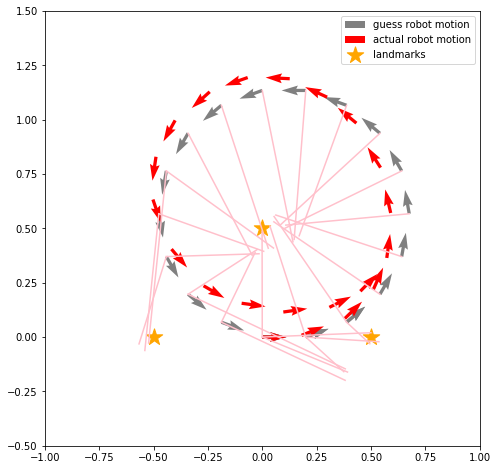

In [8]:
### 最初のステップ

robot = Robot(0,0,0)         # ロボットを置く
guess_id = 0                       #　観測された時刻に0から順番に番号をつけていくための変数
    
for i in range(0,20):
    obss = robot.observation(actual_landmarks)    # ランドマーク観測
    robot.observed.append(len(obss) > 0)              # ランドマークが一つでも観測されたらフラグをTrueにしておく。
    for obs in obss:  # 各観測データをHalfEdgeに登録
        e = HalfEdge(guess_id, obs.lid, robot.guessPose(),obs.distance, obs.direction, obs.orientation)
        obs_edges.append(e)

    if len(obss) > 0:
        guess_id += 1          # ランドマークが観測されたらidを進める

    robot.move(0.2,math.pi / 180.0 * 20)      # ロボットを移動

draw()
    
# ランドマーク観測を行えなかった時刻のロボットの情報を消去する。
# これを残すと情報行列の逆行列が作れなくなるので。
# TODO: もうちょい洗練された実装を。
a = []
g = []
for i,obs in enumerate(robot.observed):   # observedフラグが立ったときの姿勢の真値と推定値だけ残す処理
    if obs:
        a.append(robot.actual_poses[i])
        g.append(robot.guess_poses[i])

# 中身を入れ替え
robot.actual_poses = a
robot.guess_poses = g     # これがSLAMで繰り返し計算するときの最初の姿勢の推定値となる
robot.observed = []

### SLAM前の状態

赤い矢印が真値、灰色がデッドレコニングの情報です。灰色の矢印を赤色の矢印に近づけるのがSLAMの目的になります。ピンク色の線は、ランドマーク観測を表しています。線の先が、デッドレコニング情報とセンサ情報を信じたときに観測されたランドマークがどこにあるかを示していますが、これもSLAMがうまくいくと線の先が真のランドマークの位置に揃います（観測データに大きな雑音が入った時は除く）。

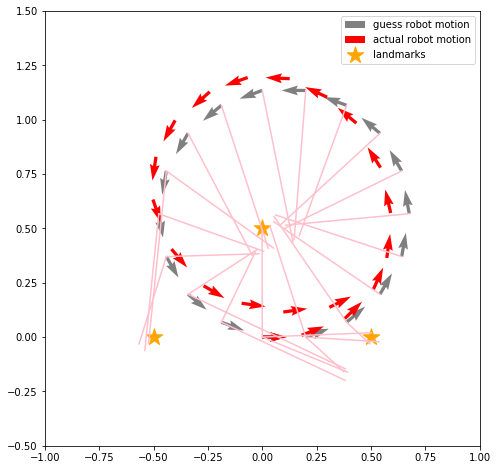

In [9]:
draw()

### SLAMの実行

各ステップの姿勢の各パラメータに対応する大きな情報行列（行、列の次元: ステップ数*姿勢の変数3）と、同じ次元数の情報ベクトルを作り、そこに各エッジの情報を足し混んでいきます。

iteration: 0, diff: 0.540861
iteration: 1, diff: 0.001303
iteration: 2, diff: 0.000001


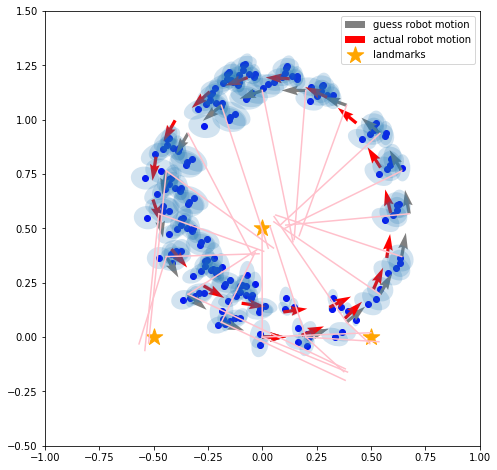

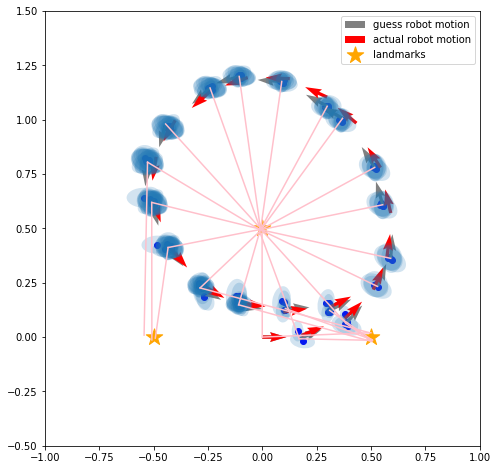

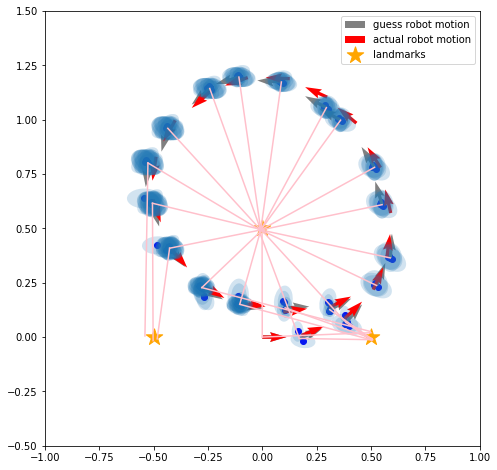

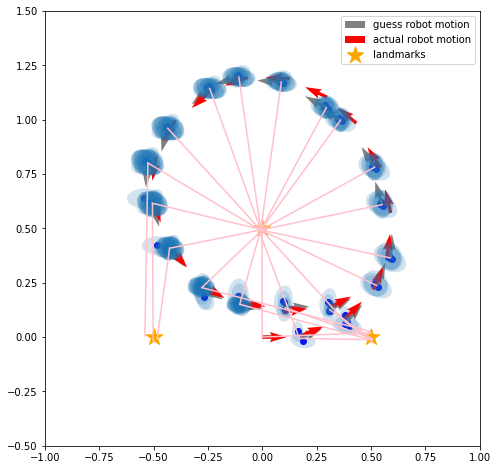

In [10]:
import itertools

for itr in range(20):      # 収束するまで繰り返しますが、上限を20回に
    pos_edges = []

    # このfor文では、HalfEdgeからグラフの辺を作っていきます。
    for i in range(len(actual_landmarks.positions)):                           # ランドマークごとにHalfEdgeからEdgeを作る
        es = list(filter(lambda e: e.landmark_id == i, obs_edges))      # 同じランドマークIDを持つHalfEdgeの抽出
        ps = list(itertools.combinations(es,2))                                       # esの要素のペアを全通り作る
        for p in ps:
            pos_edges.append(Edge(p[0],p[1]))                                    # エッジを登録
            
    draw(itr)

    # 空の情報行列と情報ベクトルを作成
    n = len(robot.guess_poses)*3
    matH = np.zeros((n,n))
    vecb = np.zeros((n,1))

    # エッジの情報を足していく
    for e in pos_edges:
        e.addInfo(matH,vecb)

    # 原点を固定するために最初の3変数に大きな情報を与える
    matH[0:3,0:3] += np.identity(3)*10000

    # どれだけ姿勢の推定値を変更するかは、以下の計算から算出できる（情報行列の逆行列に情報ベクトルをかけてマイナス）
    delta = - np.linalg.inv(matH).dot(vecb)

    # 推定値を更新
    for i,p in enumerate(robot.guess_poses):
        p[0] += delta[i*3,0]
        p[1] += delta[i*3+1,0]
        p[2] += delta[i*3+2,0]

    # HalfEdgeに登録してある推定値も更新
    for e in obs_edges:
        e.update(robot.guess_poses)
    
    # どれだけ推定値が変更されたかを計算して、閾値を超えたら終了
    diff = delta.T.dot(delta)
    print("iteration: %d, diff: %f" % (itr,diff))
    if diff[0,0] < 1.0e-5:        
        draw(itr+1)
        break

# TODO

* 現状、ロボットの軌道の再現だけを計算しているので、ランドマークの位置を計算するところまで実装する。
* どれだけ良い結果が得られたかを評価値で表す。